In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [38]:
df = pd.read_csv(r'/Users/lijiazheng/Desktop/python/PJMW_dataset/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)


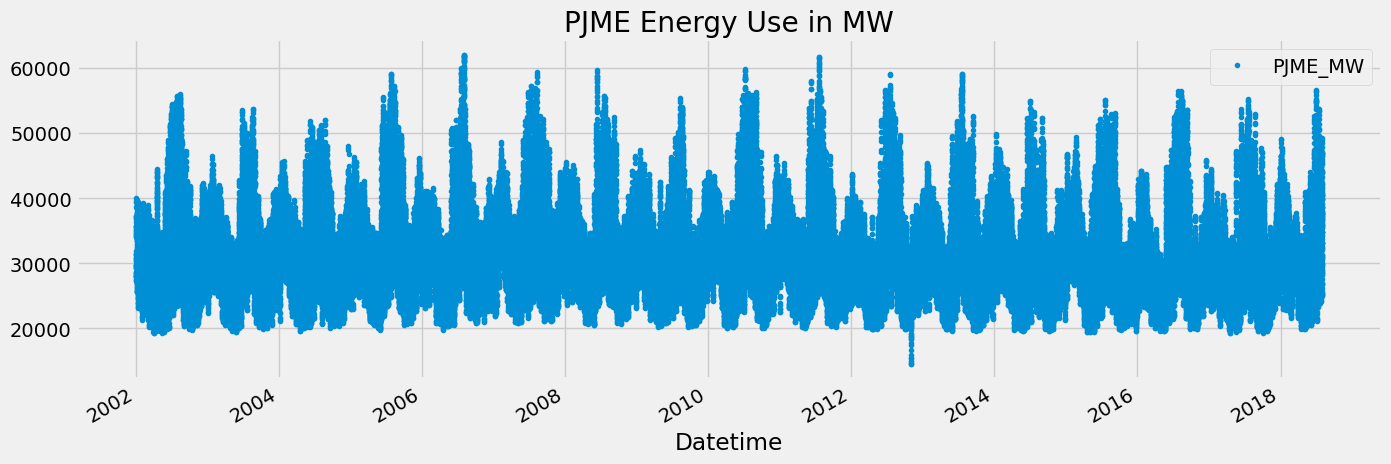

In [39]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

## Outliers Removal

<Axes: ylabel='Frequency'>

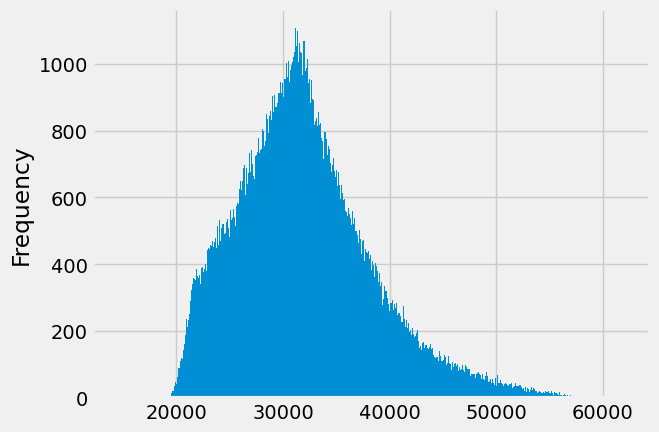

In [40]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

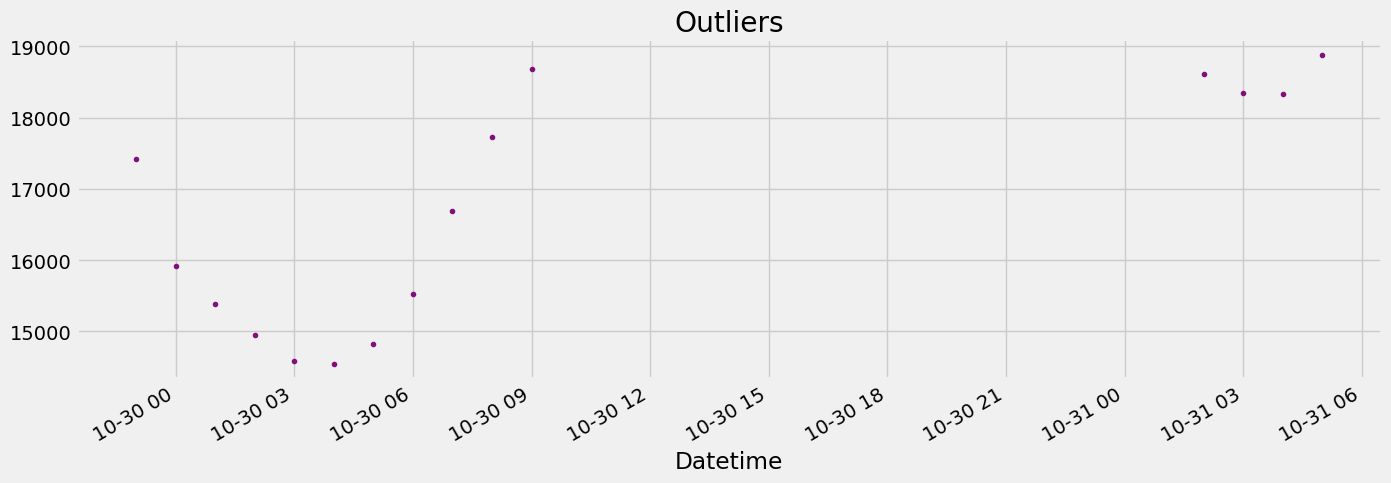

In [41]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [42]:
df = df.query('PJME_MW > 19_000').copy()

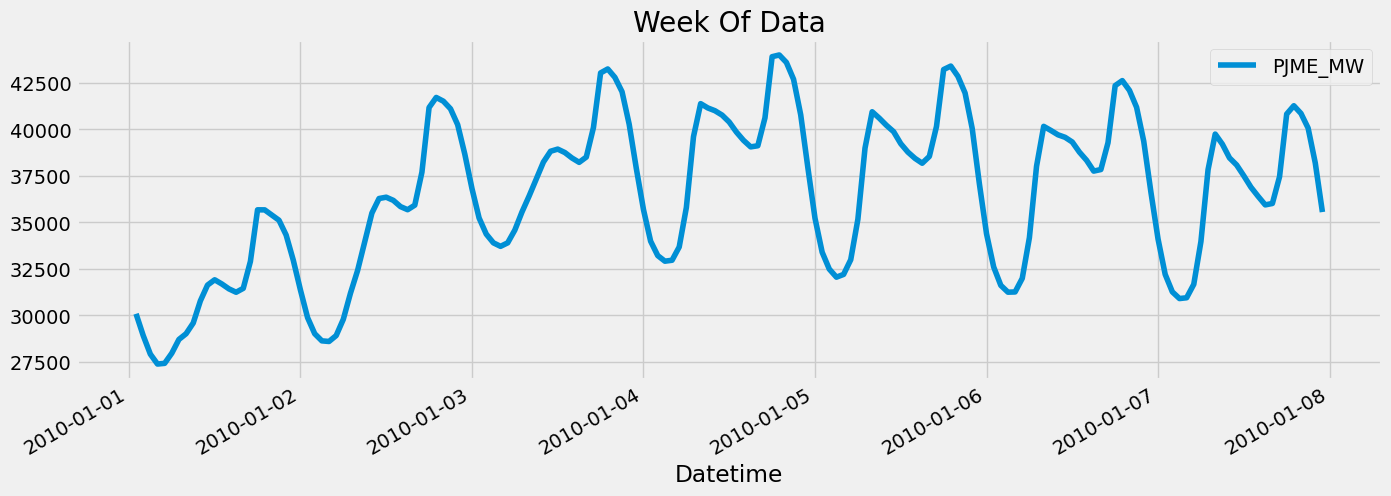

In [43]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data',legend = 'PJME : MW')
plt.show()


## Features Creation

In [44]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## Train Test Split


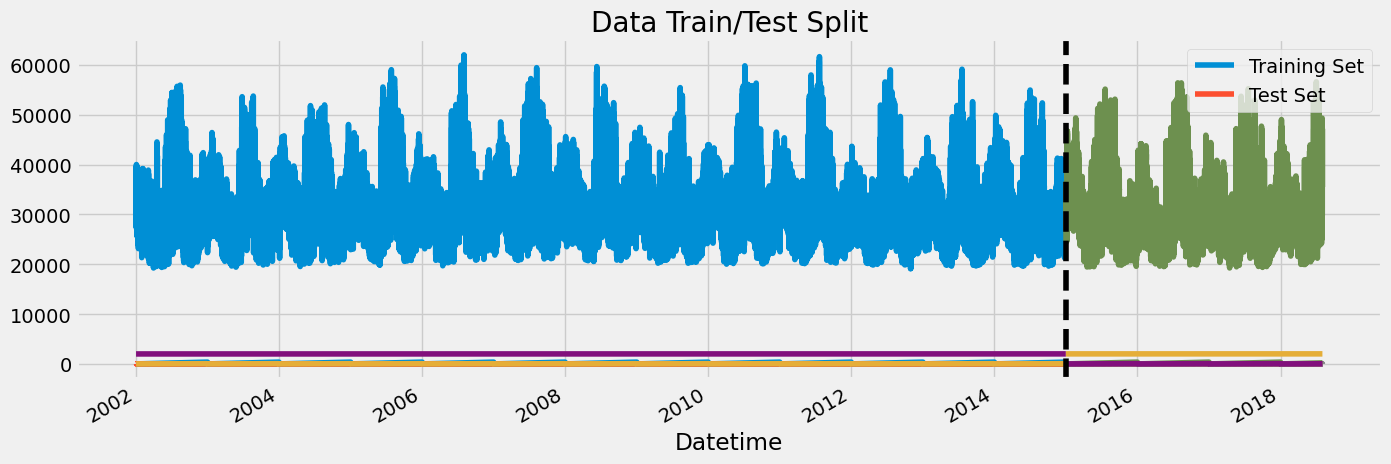

In [45]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Create Model

In [69]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [74]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[15:47:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32463.90486	validation_1-rmse:31458.91685
[100]	validation_0-rmse:12547.12464	validation_1-rmse:11657.14392
[200]	validation_0-rmse:5858.33219	validation_1-rmse:5360.40535
[300]	validation_0-rmse:3971.31303	validation_1-rmse:4090.84199
[400]	validation_0-rmse:3507.56796	validation_1-rmse:3964.38576
[500]	validation_0-rmse:3354.48842	validation_1-rmse:3937.91576
[600]	validation_0-rmse:3278.35751	validation_1-rmse:3923.29635
[700]	validation_0-rmse:3226.70498	validation_1-rmse:3904.30854
[800]	validation_0-rmse:3188.43165	validation_1-rmse:3892.40420
[878]	validation_0-rmse:3163.92505	validation_1-rmse:3890.74893


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

## Feature Importance

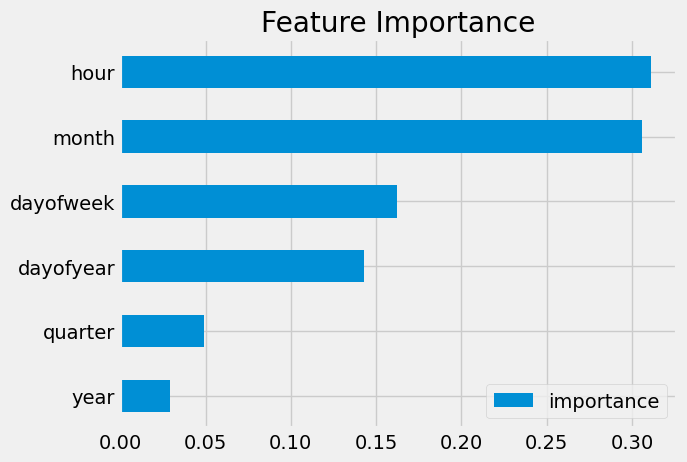

In [77]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast On Test Set

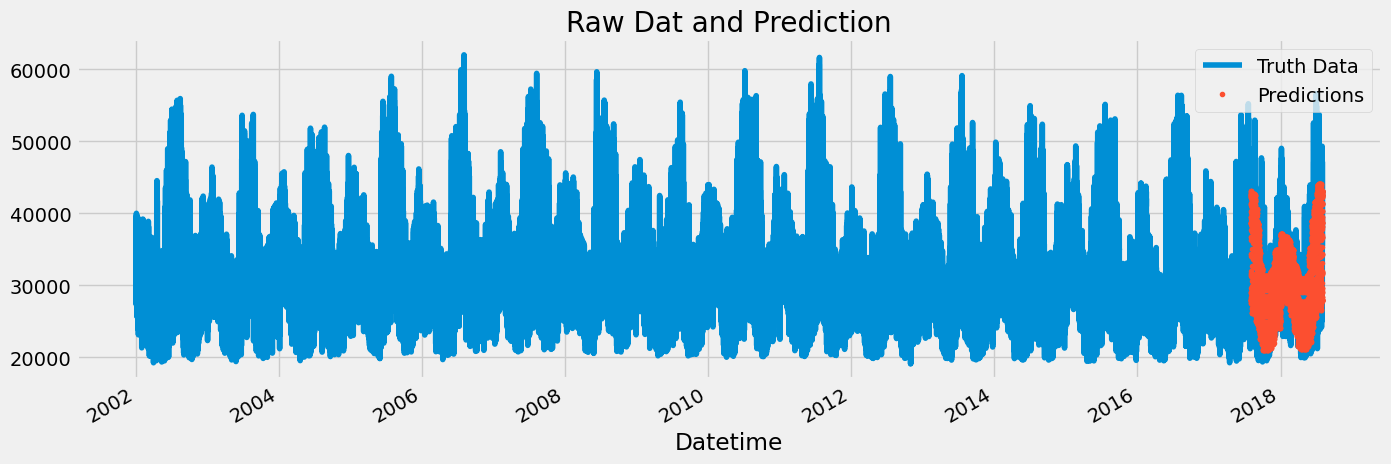

In [78]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

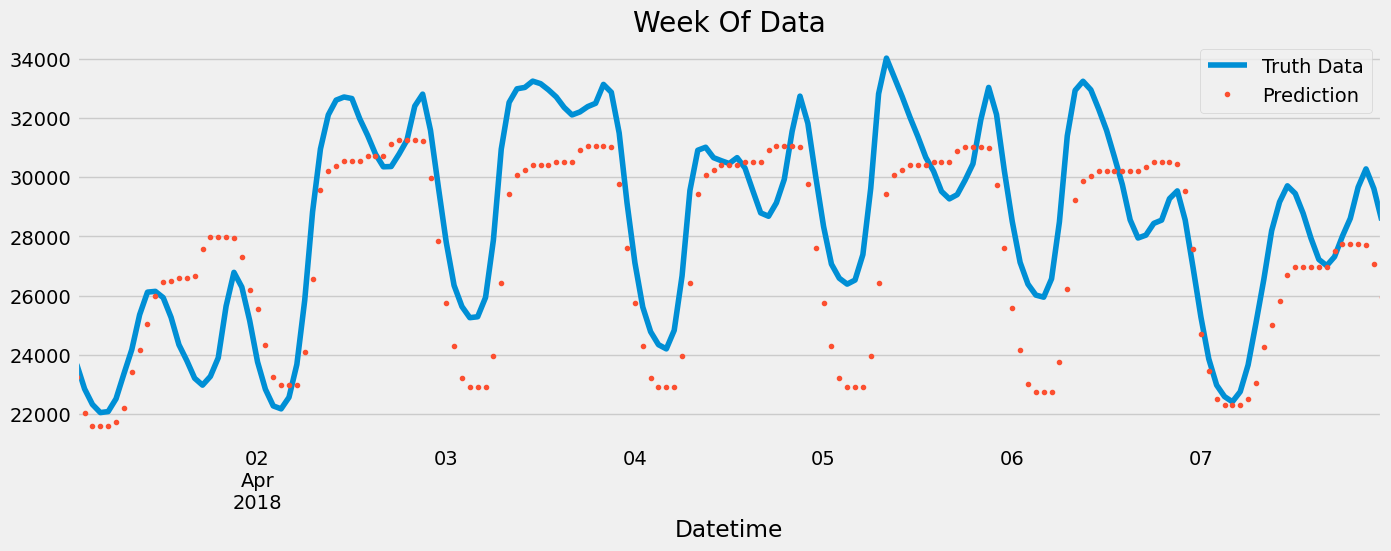

In [79]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [80]:
## Score
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3888.05


In [52]:
## Calculating error
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12806.291016
2016-08-14    12743.031169
2016-09-10    11402.480062
2015-02-20    11021.271810
2016-09-09    10848.322998
2018-01-06    10466.624023
2016-08-12    10111.824219
2015-02-21     9922.573975
2015-02-16     9856.599528
2018-01-07     9694.609945
Name: error, dtype: float64

## Times Series Cross Validation

In [53]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

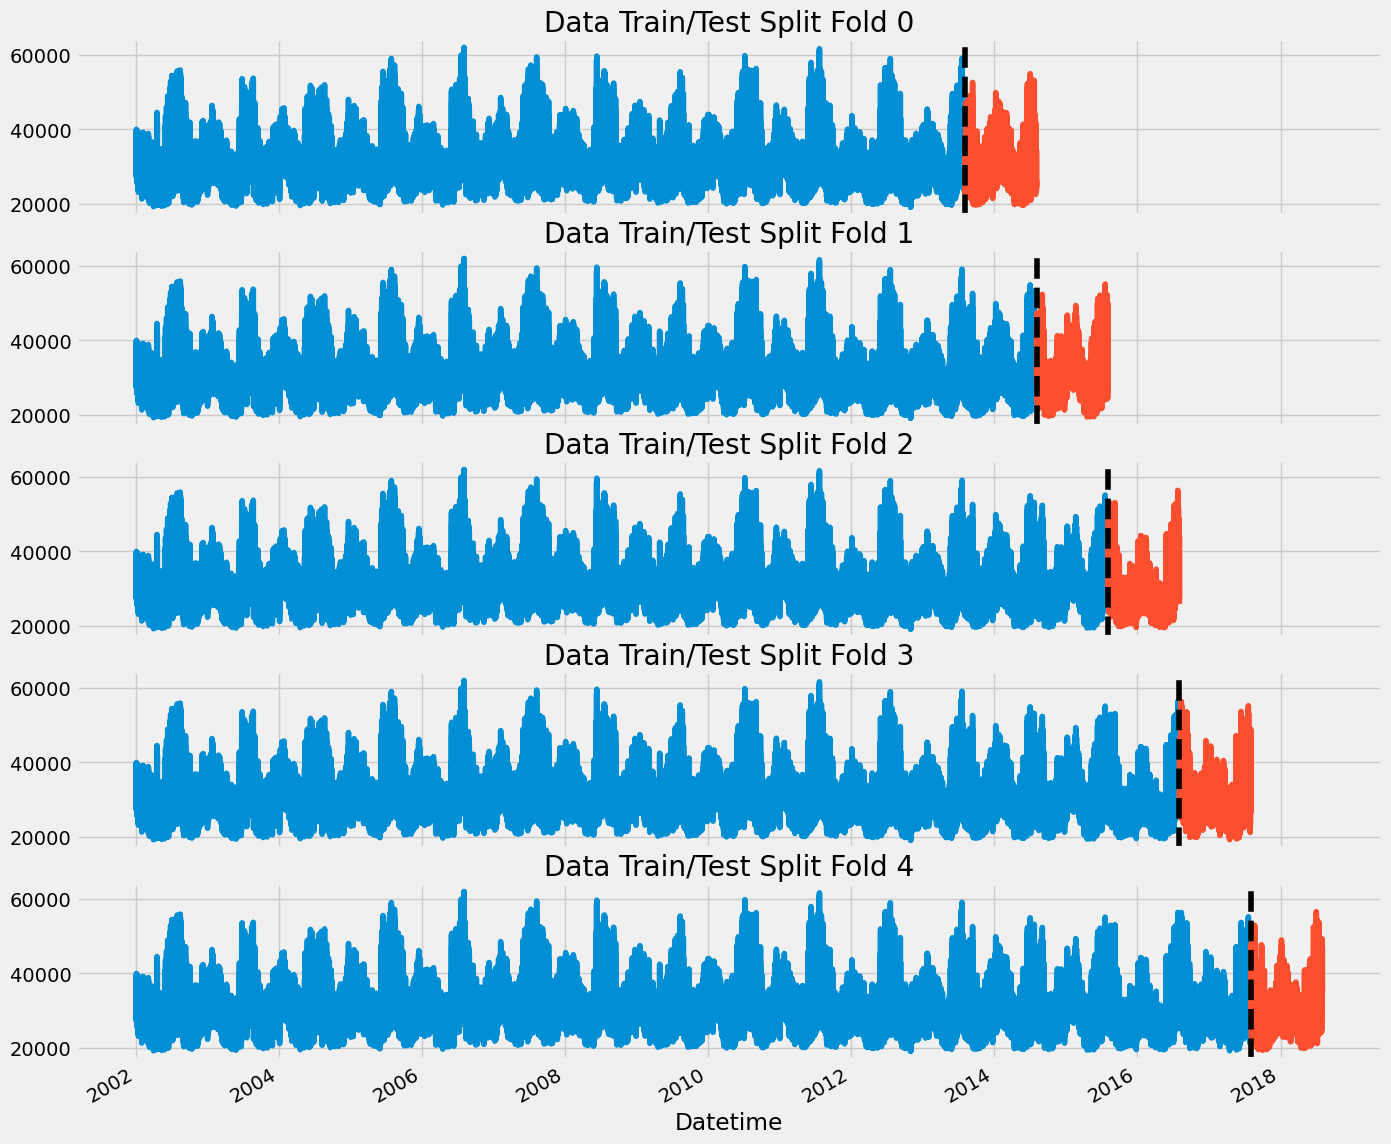

In [54]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

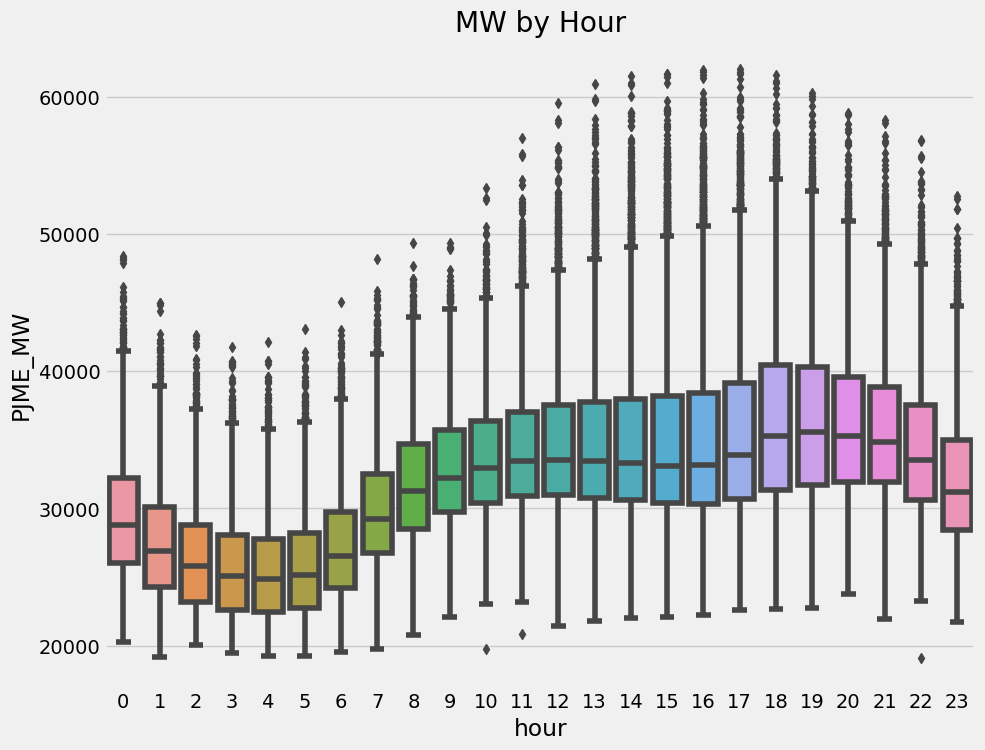

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

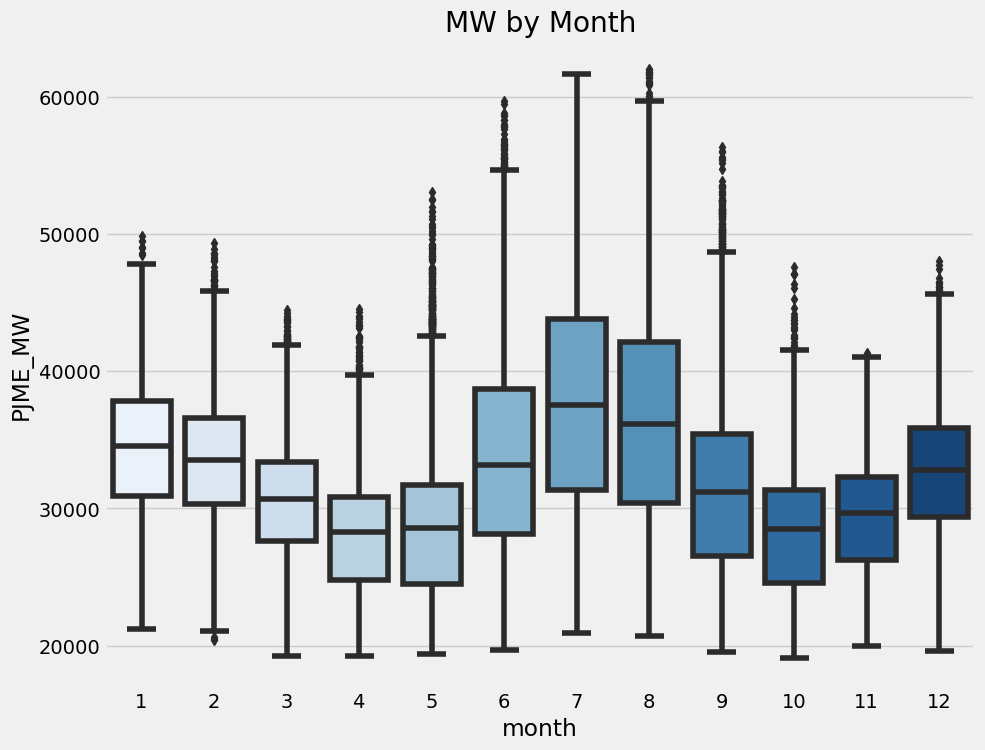

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## Lag Features

In [57]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [58]:
df = add_lags(df)

## Train Using Cross Validation

In [60]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[15:35:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.30381	validation_1-rmse:31956.18912
[100]	validation_0-rmse:12532.08851	validation_1-rmse:11907.28743
[200]	validation_0-rmse:5743.63141	validation_1-rmse:5355.87526
[300]	validation_0-rmse:3866.68176	validation_1-rmse:3890.94882
[400]	validation_0-rmse:3429.68951	validation_1-rmse:3752.67972
[450]	validation_0-rmse:3355.70585	validation_1-rmse:3759.35636
[15:35:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32671.76435	validation_1-rmse:32142.13257
[100]	validation_0-rmse:12513.14073	validation_1-rmse:12225.51268
[200]	validation_0-rmse:5755.09841	validation_

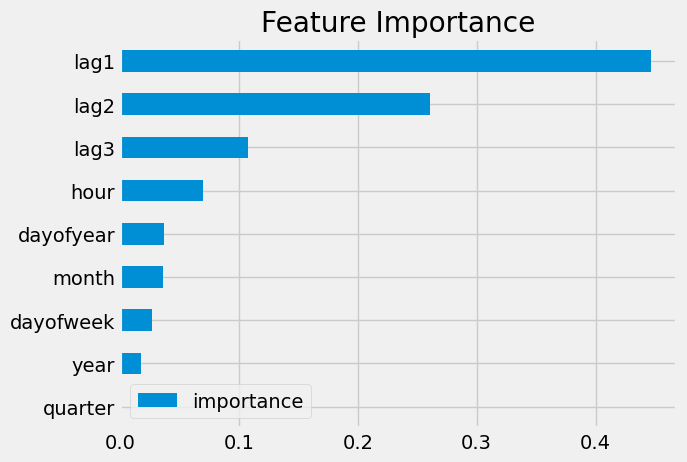

In [63]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Predicting the Future

In [64]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[15:41:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.49915
[100]	validation_0-rmse:12426.33494
[200]	validation_0-rmse:5751.05496
[300]	validation_0-rmse:3969.60349
[400]	validation_0-rmse:3568.77505
[499]	validation_0-rmse:3454.87560


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [65]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [66]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [67]:
future_w_features = df_and_future.query('isFuture').copy()

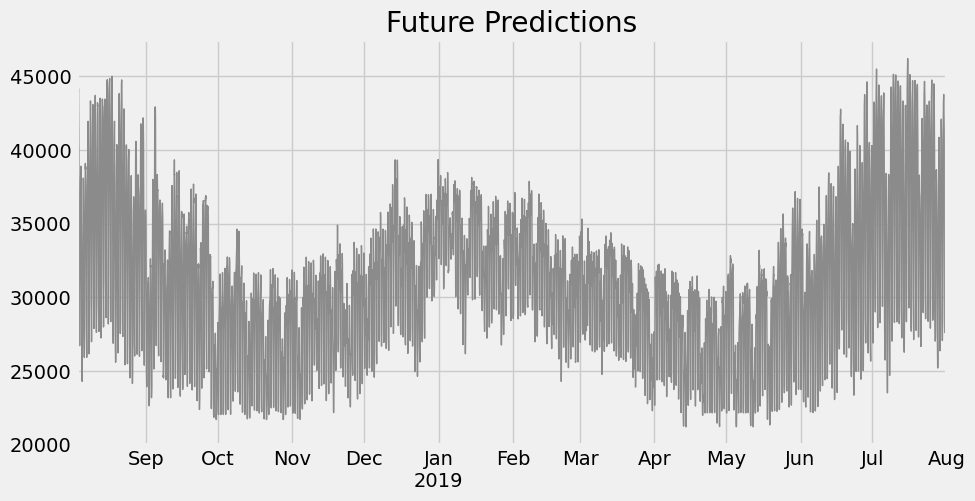

In [68]:
## Predict the future

future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

## Save Model

In [134]:
reg.save_model('model.json')

In [135]:
!ls -lh

total 145232
drwx------@  3 lijiazheng  staff    96B Nov  6  2022 Applications
drwx------@ 27 lijiazheng  staff   864B Sep 16 19:53 Desktop
drwx------@  5 lijiazheng  staff   160B Sep 16 19:50 Documents
drwx------+ 34 lijiazheng  staff   1.1K Sep 16 19:48 Downloads
drwx------@ 98 lijiazheng  staff   3.1K Sep 14 14:35 Library
drwx------+  4 lijiazheng  staff   128B Jan 21  2023 Movies
drwx------+  6 lijiazheng  staff   192B Jan 21  2023 Music
drwx------+  5 lijiazheng  staff   160B Aug 25  2022 Pictures
drwxr-xr-x+  5 lijiazheng  staff   160B Aug  2  2017 Public
-rw-r--r--   1 lijiazheng  staff    30M Aug 12 17:42 Untitled.ipynb
-rw-r--r--   1 lijiazheng  staff    39M Aug 12 17:47 Untitled1.ipynb
-rw-r--r--   1 lijiazheng  staff   1.0K Aug 26 14:03 Untitled10.ipynb
-rw-r--r--   1 lijiazheng  staff   5.9K Aug 29 13:48 Untitled11.ipynb
-rw-r--r--   1 lijiazheng  staff   1.1M Sep 17 00:55 Untitled2.ipynb
-rw-r--r--   1 lijiazheng  staff   1.2K Aug 12 17:54 Untitled3.ipynb
-rw-r--r--   1 li

<Axes: title={'center': 'Future Predictions'}>

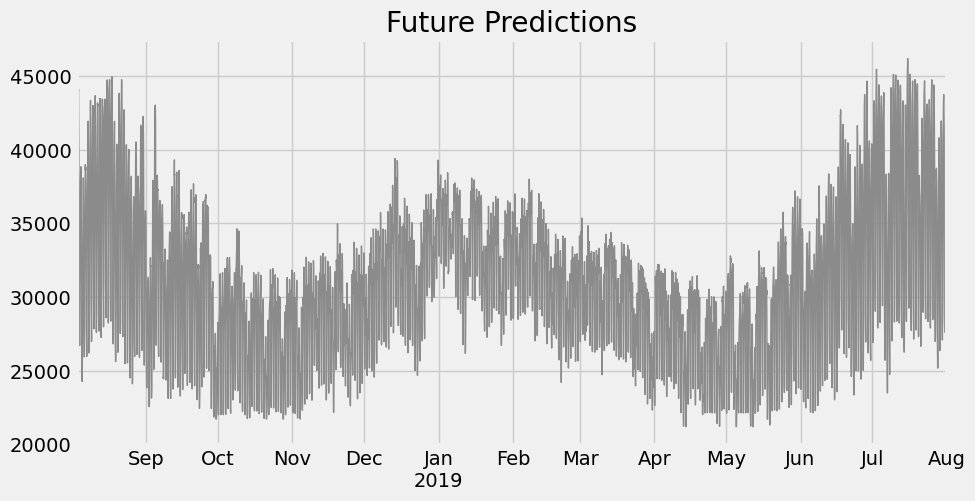

In [136]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')